In [369]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import glm
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
import seaborn as sns
from sklearn.compose import ColumnTransformer
from patsy import dmatrices
from sklearn.externals import joblib
import warnings
warnings.filterwarnings('ignore')

In [370]:
df= pd.read_csv('Output_files/Data_pre.csv')

In [371]:
df.tail()

,state,sqft,claims,exposure,month,age_bins,freq
3517,FL,19760,3,19.760,1,50,0.151822
3518,AZ,6894,4,6.894,1,80,0.580215
3519,AZ,6894,5,6.894,1,80,0.725268
3520,AZ,30015,6,30.015,1,60,0.199900
3521,AZ,30015,5,30.015,1,60,0.166583


In [372]:
df["state"].value_counts()

AZ    2118
FL    1052
OH     352
Name: state, dtype: int64

Transforming the state into numerical values using dummies lib 

In [373]:
transformed=pd.get_dummies(df['state'])
df=pd.concat((df,transformed),axis=1)

In [374]:
transformed=pd.get_dummies(df['month'])
df=pd.concat((df,transformed),axis=1)

In [375]:
df=df.drop(['state','month'],axis=1)

In [376]:

df=df.rename(columns={5: 'May',10:'Oct',1:'Jan'})

In [377]:
df.head()

,sqft,claims,exposure,age_bins,freq,AZ,FL,OH,Jan,May,Oct
0,75772,5,75.772,40,0.065987,0,1,0,1,0,0
1,75772,4,75.772,40,0.052790,0,1,0,1,0,0
2,62822,1,62.822,20,0.015918,1,0,0,1,0,0
3,62822,4,62.822,20,0.063672,1,0,0,1,0,0
4,98971,7,98.971,90,0.070728,1,0,0,1,0,0


Training only on 60% of the data and then modelling using GL stat package

In [378]:
mask = np.random.rand(len(df)) < 0.6
df_train = df[mask]
df_test = df[~mask]

In [379]:
expr = 'claims ~FL+OH+AZ+age_bins+Jan+May+Oct'
#Let’s use Patsy to carve out the X and y matrices for the training and testing data sets:

y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')
#Using the statsmodels GLM class, train the Poisson regression model on the training data set.

poisson_training_results = sm.GLM(y_train, X_train,exposure=np.asarray(df_train['exposure']),family=sm.families.Poisson()).fit()
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 claims   No. Observations:                 2067
Model:                            GLM   Df Residuals:                     2061
Model Family:                 Poisson   Df Model:                            5
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5677.9
Date:                Wed, 03 Nov 2021   Deviance:                       4768.6
Time:                        17:31:11   Pearson chi2:                 9.11e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.7549      0.016   -107.823      0.0

There are high dispersion(4711.9) and we try to reduce the no of features to avoid multicollinearity

In [380]:
expr = 'claims ~FL+AZ+age_bins+May+Oct'
#Let’s use Patsy to carve out the X and y matrices for the training and testing data sets:

y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')
#Using the statsmodels GLM class, train the Poisson regression model on the training data set.


poisson_training_results = sm.GLM(y_train, X_train,exposure=np.asarray(df_train['exposure']),family=sm.families.Poisson()).fit()
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 claims   No. Observations:                 2067
Model:                            GLM   Df Residuals:                     2061
Model Family:                 Poisson   Df Model:                            5
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5677.9
Date:                Wed, 03 Nov 2021   Deviance:                       4768.6
Time:                        17:31:11   Pearson chi2:                 9.11e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.6697      0.039    -69.244      0.0

 by reducing the features we don't see any changes in 'Deviance' and 'Log-Likelihood' but for OC p values is greater than .05

In [381]:
expr = 'claims ~FL+OH+age_bins+May'
#Let’s use Patsy to carve out the X and y matrices for the training and testing data sets:

y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')
#Using the statsmodels GLM class, train the Poisson regression model on the training data set.

poisson_training_results = sm.GLM(y_train, X_train,exposure=np.asarray(df_train['exposure']),family=sm.families.Poisson()).fit()
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 claims   No. Observations:                 2067
Model:                            GLM   Df Residuals:                     2062
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5681.5
Date:                Wed, 03 Nov 2021   Deviance:                       4775.8
Time:                        17:31:12   Pearson chi2:                 9.11e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.1896      0.030   -107.103      0.0

By trying different features "FL,age_bins,OH" features give optium devaiance using poission fit

Now we see there is high devvaince due to high variance for which we use NegativeBinomial

In [382]:
expr = 'claims ~FL+age_bins+OH'
#Let’s use Patsy to carve out the X and y matrices for the training and testing data sets:

y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')
#Using the statsmodels GLM class, train the Poisson regression model on the training data set.

poisson_training_results = sm.GLM(y_train, X_train,exposure=np.asarray(df_train['exposure']), family=sm.families.NegativeBinomial(alpha = 1.5)).fit()
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 claims   No. Observations:                 2067
Model:                            GLM   Df Residuals:                     2063
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5942.8
Date:                Wed, 03 Nov 2021   Deviance:                       980.75
Time:                        17:31:12   Pearson chi2:                 2.41e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.8409      0.070    -40.320      0.0

In [383]:
poisson_predictions = poisson_training_results.get_prediction(X_test)
#summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

          mean   mean_se  mean_ci_lower  mean_ci_upper
0     0.118301  0.006619       0.106013       0.132012
2     0.072083  0.003889       0.064849       0.080123
4     0.150810  0.007917       0.136064       0.167154
5     0.150810  0.007917       0.136064       0.167154
9     0.080100  0.003774       0.073035       0.087848
...        ...       ...            ...            ...
3513  0.080100  0.003774       0.073035       0.087848
3514  0.135715  0.006232       0.124034       0.148497
3515  0.135715  0.006232       0.124034       0.148497
3516  0.131458  0.007053       0.118336       0.146035
3518  0.135715  0.006232       0.124034       0.148497

[1455 rows x 4 columns]


In [384]:
predicted_claims=predictions_summary_frame['mean']*df_test['exposure']

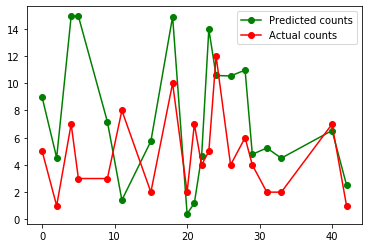

In [385]:
predicted_counts=predicted_claims
actual_counts = y_test['claims']
fig = plt.figure()
predicted, = plt.plot(X_test.index[:20], predicted_counts[:20], 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index[:20], actual_counts[:20], 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

In [386]:
df_train, df_test = train_test_split(df, test_size=0.33, random_state=0)

In [387]:
from sklearn.linear_model import PoissonRegressor
preprocessor = ColumnTransformer(
    [
        ("numeric", "passthrough", ['FL','OH','age_bins']),
    ],
    remainder="drop",
)
n_samples = df_train.shape[0]

poisson_glm = Pipeline(
    [     ("preprocessor", preprocessor),
        ("regressor", PoissonRegressor(alpha=1e-12, max_iter=300)),
    ]
)
poisson_glm.fit(
    df_train, df_train["freq"], regressor__sample_weight=df_train["exposure"]
)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', 'passthrough',
                                                  ['FL', 'OH', 'age_bins'])])),
                ('regressor', PoissonRegressor(alpha=1e-12, max_iter=300))])

In [388]:

from sklearn.metrics import mean_poisson_deviance
mask = y_pred > 0
y_pred = poisson_glm.predict(df_test)
print(mean_poisson_deviance(
            df_test["freq"][mask],
            y_pred[mask],
            sample_weight=df_test["exposure"][mask]))

0.041753228026744894


In [389]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder


poisson_gbrt = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "regressor",
            HistGradientBoostingRegressor(loss="poisson", max_leaf_nodes=150),
        ),
    ]
)
poisson_gbrt.fit(
    df_train, df_train["freq"], regressor__sample_weight=df_train["exposure"]
)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', 'passthrough',
                                                  ['FL', 'OH', 'age_bins'])])),
                ('regressor',
                 HistGradientBoostingRegressor(loss='poisson',
                                               max_leaf_nodes=150))])

In [390]:

mask = y_pred > 0
y_pred = poisson_gbrt.predict(df_test)
print(mean_poisson_deviance(
            df_test["freq"][mask],
            y_pred[mask],
            sample_weight=df_test["exposure"][mask]))

0.041965540901764825


Reference for below code "https://scikit-learn.org/stable/auto_examples/linear_model/plot_poisson_regression_non_normal_loss.html#sphx-glr-auto-examples-linear-model-plot-poisson-regression-non-normal-loss-py"

Actual number of claims: 5079
Predicted number of claims by PoissonRegressor(alpha=1e-12, max_iter=300): 5158.7
Predicted number of claims by HistGradientBoostingRegressor(loss='poisson', max_leaf_nodes=150): 5121.5


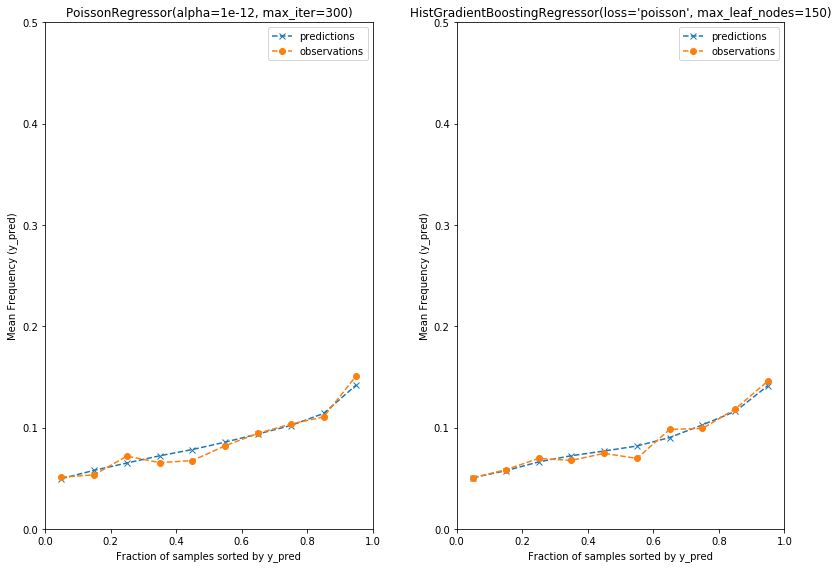

In [391]:
from sklearn.utils import gen_even_slices


def _mean_frequency_by_risk_group(y_true, y_pred, sample_weight=None, n_bins=100):
    """Compare predictions and observations for bins ordered by y_pred.

    We order the samples by ``y_pred`` and split it in bins.
    In each bin the observed mean is compared with the predicted mean.

    Parameters
    ----------
    y_true: array-like of shape (n_samples,)
        Ground truth (correct) target values.
    y_pred: array-like of shape (n_samples,)
        Estimated target values.
    sample_weight : array-like of shape (n_samples,)
        Sample weights.
    n_bins: int
        Number of bins to use.

    Returns
    -------
    bin_centers: ndarray of shape (n_bins,)
        bin centers
    y_true_bin: ndarray of shape (n_bins,)
           average y_pred for each bin
    y_pred_bin: ndarray of shape (n_bins,)
        average y_pred for each bin
    """
    idx_sort = np.argsort(y_pred)
    bin_centers = np.arange(0, 1, 1 / n_bins) + 0.5 / n_bins
    y_pred_bin = np.zeros(n_bins)
    y_true_bin = np.zeros(n_bins)

    for n, sl in enumerate(gen_even_slices(len(y_true), n_bins)):
        weights = sample_weight[idx_sort][sl]
        y_pred_bin[n] = np.average(y_pred[idx_sort][sl], weights=weights)
        y_true_bin[n] = np.average(y_true[idx_sort][sl], weights=weights)
    return bin_centers, y_true_bin, y_pred_bin


print(f"Actual number of claims: {df_test['claims'].sum()}")
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
plt.subplots_adjust(wspace=0.3)

for axi, model in zip(ax.ravel(), [poisson_glm,poisson_gbrt]):
    y_pred = model.predict(df_test)
    y_true = df_test["freq"].values
    exposure = df_test["exposure"].values
    q, y_true_seg, y_pred_seg = _mean_frequency_by_risk_group(
        y_true, y_pred, sample_weight=exposure, n_bins=10
    )

    # Name of the model after the estimator used in the last step of the
    # pipeline.
    print(f"Predicted number of claims by {model[-1]}: {np.sum(y_pred * exposure):.1f}")

    axi.plot(q, y_pred_seg, marker="x", linestyle="--", label="predictions")
    axi.plot(q, y_true_seg, marker="o", linestyle="--", label="observations")
    axi.set_xlim(0, 1.0)
    axi.set_ylim(0, 0.5)
    axi.set(
         title=model[-1],
        xlabel="Fraction of samples sorted by y_pred",
        ylabel="Mean Frequency (y_pred)",
    )
    axi.legend()
plt.tight_layout()

In [392]:
import pickle
 
# Load the pickled model
# Save the Modle to file in the current working directory

Pkl_Filename = "Poisson_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(poisson_gbrt, file)